# 파일 다운

In [70]:
!wget https://github.com/dhrim/deep_learning_data/raw/master/MRI_images.zip

--2022-01-05 01:39:25--  https://github.com/dhrim/deep_learning_data/raw/master/MRI_images.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/deep_learning_data/master/MRI_images.zip [following]
--2022-01-05 01:39:25--  https://raw.githubusercontent.com/dhrim/deep_learning_data/master/MRI_images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24016661 (23M) [application/zip]
Saving to: ‘MRI_images.zip.3’

MRI_images.zip.3    100%[===================>]  22.90M   138MB/s    in 0.2s    

2022-01-05 01:39:26 (138 MB/s) - ‘MRI_images.zip.3’ saved [24016661/24016661]



In [71]:
!unzip MRI_images.zip

Archive:  MRI_images.zip
replace MRI_images/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# 파일 리스트 구하기

In [90]:
import glob
label_file_list = glob.glob("MRI_images/*_mask.tif")

# some_mask.tif 파일 이름에서 some.tif 파일 이름 구하기

In [91]:
image_file_list = [file_name.replace("_mask","") for file_name in label_file_list]
print(len(image_file_list))
print(image_file_list[:5])

218
['MRI_images/TCGA_CS_5393_19990606_14.tif', 'MRI_images/TCGA_CS_5397_20010315_6.tif', 'MRI_images/TCGA_CS_5393_19990606_7.tif', 'MRI_images/TCGA_CS_5397_20010315_12.tif', 'MRI_images/TCGA_CS_4941_19960909_3.tif']


In [92]:
print("some_mask.tif".replace("_mask",""))

some.tif


# tif 파일 읽기

In [93]:
import numpy as np
import matplotlib.pyplot as plt

images= []
for file_name in  image_file_list:
  images.append(plt.imread(file_name))
images = np.array(images)
print(len(images))


labels= []
for file_name in  label_file_list:
  labels.append(plt.imread(file_name))
labels = np.array(labels)
print(len(labels))

218
218


In [94]:
print(images.shape)
print(labels.shape)

(218, 256, 256, 3)
(218, 256, 256)


# 읽은 영상 확인

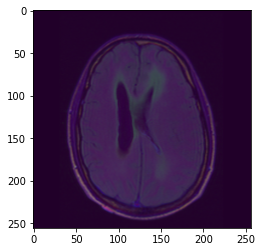

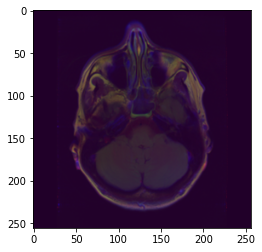

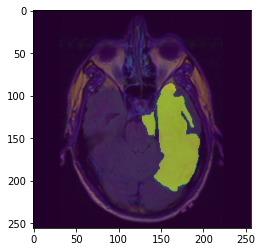

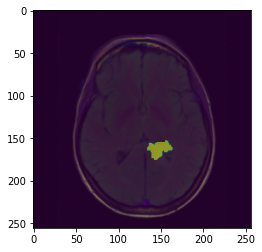

In [95]:
for i in range(4):
  plt.imshow(images[i])
  plt.imshow(labels[i], alpha = 0.5) # alpha = 투명도
  plt.show()

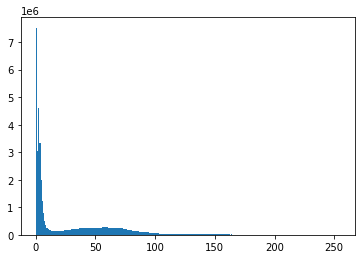

[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]


In [96]:
plt.hist(images.flatten(), bins = 256)
plt.show()
print(images[0][0][0:10])

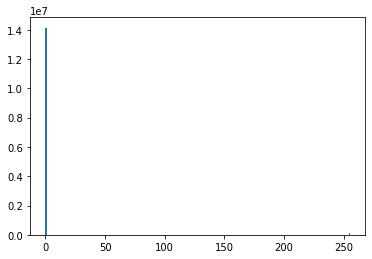

[0 0 0 0 0 0 0 0 0 0]
[  0 255]


In [97]:
plt.hist(labels.flatten(), bins = 256)
plt.show()
print(labels[0][0][0:10])
print(np.unique(labels))  # unique 값 출력

# 데이터 전처리

In [98]:
images = (images / 255.).astype(np.float)
labels = (labels / 255.).astype(np.int)

In [99]:
print(np.min(images), np.max(images))
print(np.min(labels), np.max(labels))

0.0 1.0
0 1


In [100]:
labels = np.expand_dims(labels, axis = -1)

In [101]:
print(images.shape)
print(labels.shape)

(218, 256, 256, 3)
(218, 256, 256, 1)


In [102]:
x = images 
y = labels

# 데이터 나누기

In [103]:
split_index = int(x.shape[0]*0.8)
train_x, test_x = x[:split_index], x[split_index:]
train_y, test_y = y[:split_index], y[split_index:]

In [104]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(174, 256, 256, 3)
(174, 256, 256, 1)
(44, 256, 256, 3)
(44, 256, 256, 1)


train


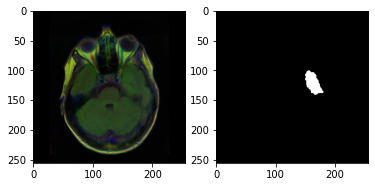

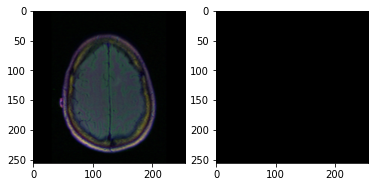

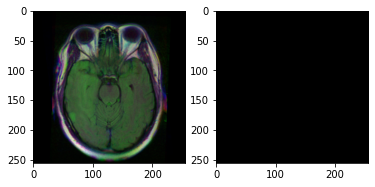

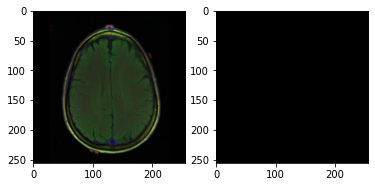

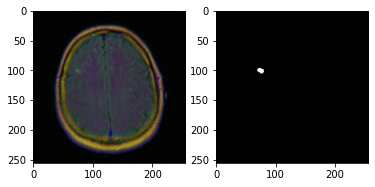

test


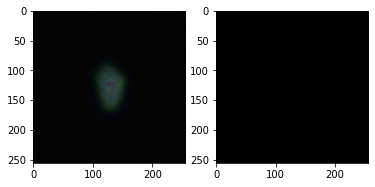

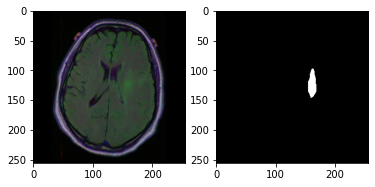

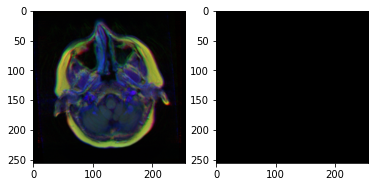

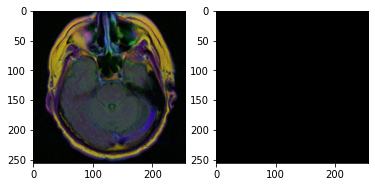

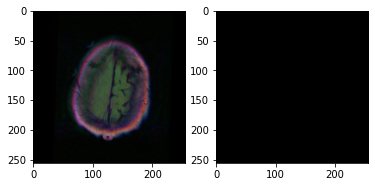

In [105]:
import matplotlib.pyplot as plt

def plotTrainData(x, y, set_type):
    print(set_type)  
    for i in range(5):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(train_x, train_y, 'train')
plotTrainData(test_x, test_y, 'test')

## U-Net 모델 정의

In [106]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up, conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up, conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

## 모델 컴파일과 학습

In [124]:
# 모델 생성
model = unet()

import tensorflow
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001*0.1) # ㅣloss감소 코드
# 모델 컴파일
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=500, batch_size=32, verbose=1)


Epoch 1/500
5/5 [==============================] - 4s 393ms/step - loss: 0.7913 - accuracy: 0.5033 - val_loss: 0.6959 - val_accuracy: 0.3135
Epoch 2/500
5/5 [==============================] - 1s 293ms/step - loss: 0.7495 - accuracy: 0.5080 - val_loss: 0.6919 - val_accuracy: 0.6157
Epoch 3/500
5/5 [==============================] - 1s 289ms/step - loss: 0.7263 - accuracy: 0.5692 - val_loss: 0.6895 - val_accuracy: 0.6643
Epoch 4/500
5/5 [==============================] - 1s 291ms/step - loss: 0.7090 - accuracy: 0.5913 - val_loss: 0.6880 - val_accuracy: 0.6720
Epoch 5/500
5/5 [==============================] - 1s 291ms/step - loss: 0.6957 - accuracy: 0.5906 - val_loss: 0.6869 - val_accuracy: 0.6643
Epoch 6/500
5/5 [==============================] - 1s 290ms/step - loss: 0.6879 - accuracy: 0.6311 - val_loss: 0.6853 - val_accuracy: 0.6577
Epoch 7/500
5/5 [==============================] - 1s 291ms/step - loss: 0.6788 - accuracy: 0.6645 - val_loss: 0.6832 - val_accuracy: 0.6615
Epoch 8/500
5

# 학습 시 로스와 정확도 확인

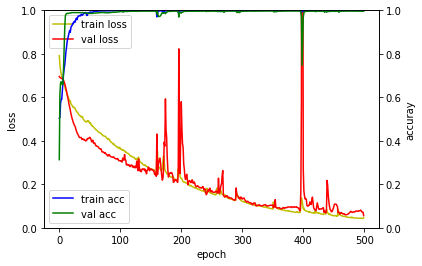

In [125]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 테스트 결과 보기

In [126]:
import matplotlib.pyplot as plt

def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

1/1 [==============================] - 0s 21ms/step - loss: 0.0458 - accuracy: 0.9960


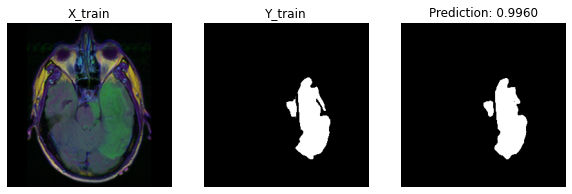

1/1 [==============================] - 0s 21ms/step - loss: 0.0388 - accuracy: 1.0000


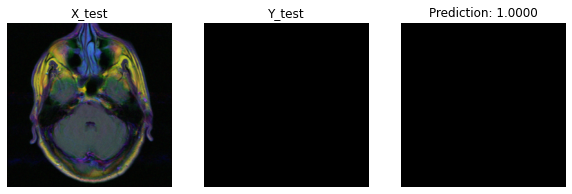

In [127]:
plotPredictions(model, train_x, train_y, test_x, test_y)